The notebook shows an example how text files, labelled for sentiment (positive or negative), can be converted to numerical representations using a LLM (BERT, in this example) and then used to train a machine learning model capable of classifying new texts by sentiment.

<mark>Note on a regular laptop or Google Colab, only BERT-tiny fits the memory with the number of input tokens = 128, resulting in classification accuracy lower than BoW on full-text documents.</mark>

As an example, we will use a corpus of movie reviews first used in Pang and Lee (2004), for details see [here](http://www.cs.cornell.edu/people/pabo/movie-review-data/).

Ensure that tensorflow, tensorflow-hub and tensorflow-text are installed:

In [1]:
!pip install transformers

'pip' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
# setting logging to print only error messages of sklearnex
import logging
logging.basicConfig()
logging.getLogger("SKLEARNEX").setLevel(logging.ERROR)

import pandas as pd
import matplotlib.pyplot as plt

import torch
from transformers import AutoTokenizer, AutoModel

from sklearn.model_selection import GridSearchCV

# execution time
from timeit import default_timer as timer
from datetime import timedelta

# Load the data

If the data has not been downloaded before, download it, and save to a folder called "datasets", alongside this notebook.

In [3]:
import os
import urllib
import tarfile

url = "https://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz"
    
def download_data(url):
    """Download the data and extract the mo
    """
    
    # if the "datasets" folder does not exist, create it
    if not os.path.exists("datasets"):
        os.makedirs("datasets")
    
    # if the archived file does not exist, download it
    if not os.path.exists("datasets/review_polarity.tar.gz"):
        urllib.request.urlretrieve(url, "datasets/review_polarity.tar.gz")
    
    # if the unpacked file does not exist, unpack it
    if not os.path.exists("datasets/txt_sentoken"):
        infile = tarfile.open("datasets/review_polarity.tar.gz")
        infile.extractall(path="datasets")
        infile.close()

download_data(url)

The code above will produce a folder inside "datasets", called "txt_sentoken". That folder will contain two subfolders - "pos" (containing 1000 files manually labelled as positive) and "neg" (containing 1000 files manually labelled as "negative"). Each file is a separate movie review, after minimal normalization (inserting spaces around punctuation symbols, lower-casing all words, etc).

We will use Scikit-learn's `load_files` function to load these data into a format that can be input directly into other scikit-learn tools:

In [4]:
from sklearn.datasets import load_files

# loading all files. 
movie = load_files("./datasets/txt_sentoken/", shuffle=True)

In [5]:
len(movie.data)

2000

In [6]:
# target names ("classes") are automatically generated from subfolder names
movie.target_names

['neg', 'pos']

In [7]:
# First file seems to be about a Schwarzenegger movie. 
print(movie.data[0])

b"arnold schwarzenegger has been an icon for action enthusiasts , since the late 80's , but lately his films have been very sloppy and the one-liners are getting worse . \nit's hard seeing arnold as mr . freeze in batman and robin , especially when he says tons of ice jokes , but hey he got 15 million , what's it matter to him ? \nonce again arnold has signed to do another expensive blockbuster , that can't compare with the likes of the terminator series , true lies and even eraser . \nin this so called dark thriller , the devil ( gabriel byrne ) has come upon earth , to impregnate a woman ( robin tunney ) which happens every 1000 years , and basically destroy the world , but apparently god has chosen one man , and that one man is jericho cane ( arnold himself ) . \nwith the help of a trusty sidekick ( kevin pollack ) , they will stop at nothing to let the devil take over the world ! \nparts of this are actually so absurd , that they would fit right in with dogma . \nyes , the film is 

In [8]:
movie.target[0]

0

# Train-test split

The data has been loaded by scikit-learn into a special data structure, which is neither a numpy array or a pandas dataframe. Nonetheless, we can use scikit-learn's `train_test_split` to split the data into the training and test parts:  

In [9]:
from sklearn.model_selection import train_test_split

docs_train, docs_test, ytrain, ytest = train_test_split(movie.data, movie.target, 
                                                          test_size=0.2, random_state=7)

In [10]:
print(f"{len(docs_train)} train and {len(docs_test)} test instances")

1600 train and 400 test instances


# Document embeddings

Note BERT will consume maximum 512 tokens of the document and truncate anything beyond this length.

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# other options:
#prajjwal1/bert-mini (L=4, H=256) Model Link
#prajjwal1/bert-small (L=4, H=512) Model Link
#prajjwal1/bert-medium (L=8, H=512) Model Link
# search for other models: https://huggingface.co/models?sort=trending&search=distilbert

tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-tiny")
model = AutoModel.from_pretrained("prajjwal1/bert-tiny").to(device)

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [12]:
def get_embeddings(texts):
    """Input: a list of texts
    """
    global tokenizer, model, device

    tokenized_texts = tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors="pt")
    
    tokenized_texts = {k: v.clone().detach().to(device) for k,v in tokenized_texts.items()}

    with torch.no_grad():
      hidden = model(**tokenized_texts) #dim : [batch_size(nr_sentences), tokens, emb_dim]
    
    cls_train = hidden.last_hidden_state[:, 0, :]
    
    return cls_train.to("cpu")

In [13]:
output = get_embeddings(["This is an example."])
output.shape

torch.Size([1, 128])

In [14]:
output = get_embeddings(["This is a longer example."])
output.shape

torch.Size([1, 128])

In [15]:
Xtrain = get_embeddings([str(x) for x in docs_train])
Xtrain.shape

torch.Size([1600, 128])

In [16]:
Xtest = get_embeddings([str(x) for x in docs_test])
Xtest.shape

torch.Size([400, 128])

# Train models

## Baseline

Classifying everything as "pos"

In [17]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import precision_recall_fscore_support

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(Xtrain, ytrain)
yhat = dummy_clf.predict(Xtrain)

p, r, f, s = precision_recall_fscore_support(ytrain, yhat, average="macro", zero_division=0.0)
print(f"Precision: {p:.3f}")
print(f"Recall: {r:.3f}")
print(f"F score: {f:.3f}")

Precision: 0.254
Recall: 0.500
F score: 0.337


## Decision Trees

In [18]:
start = timer()

from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier(random_state=7)

# specify the hyperparameters and their values
# 3 x 3 = 9 combinations in the grid
param_grid = {
    'max_depth': [15, 30, 50],
    'min_samples_split': [10, 20, 50],
}

# we'll use 5-fold cross-validation
grid_search = GridSearchCV(dtree, param_grid, cv=5,
                           scoring='f1_macro', 
                           return_train_score=True)
grid_search.fit(Xtrain, ytrain)

print("Execution time HH:MM:SS:", timedelta(seconds=timer() - start))

Execution time HH:MM:SS: 0:00:10.873472


In [19]:
cv_results = pd.DataFrame(grid_search.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

pd.set_option('display.max_colwidth', 100)
cv_results.sort_values('mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score,"diff, %"
0,"{'max_depth': 15, 'min_samples_split': 10}",0.956215,0.549942,42.487591
4,"{'max_depth': 30, 'min_samples_split': 20}",0.907025,0.544517,39.966658
7,"{'max_depth': 50, 'min_samples_split': 20}",0.907025,0.544517,39.966658
5,"{'max_depth': 30, 'min_samples_split': 50}",0.817553,0.541511,33.764333
8,"{'max_depth': 50, 'min_samples_split': 50}",0.817553,0.541511,33.764333
3,"{'max_depth': 30, 'min_samples_split': 10}",0.962951,0.541497,43.766955
6,"{'max_depth': 50, 'min_samples_split': 10}",0.962951,0.541497,43.766955
2,"{'max_depth': 15, 'min_samples_split': 50}",0.812286,0.539378,33.597507
1,"{'max_depth': 15, 'min_samples_split': 20}",0.902161,0.538516,40.308158


## Random Forest

In [20]:
start = timer()

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=7)

# specify the hyperparameters and their values
# 4 x 3 x 3 = 36 combinations in the grid
param_grid = {
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [5, 15, 30],
    'min_samples_split': [5, 10, 20]
}

# we'll use 5-fold cross-validation
grid_search = GridSearchCV(rf, param_grid, cv=5,
                           scoring='f1_macro', 
                           return_train_score=True)
grid_search.fit(Xtrain, ytrain)

print("Execution time HH:MM:SS:", timedelta(seconds=timer() - start))

Execution time HH:MM:SS: 0:14:42.184356


In [21]:
cv_results = pd.DataFrame(grid_search.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

pd.set_option('display.max_colwidth', 100)
cv_results.sort_values('mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score,"diff, %"
19,"{'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 1000}",1.000000,0.631355,36.864506
29,"{'max_depth': 30, 'min_samples_split': 10, 'n_estimators': 200}",1.000000,0.630955,36.904527
35,"{'max_depth': 30, 'min_samples_split': 20, 'n_estimators': 1000}",0.999687,0.629876,36.992738
31,"{'max_depth': 30, 'min_samples_split': 10, 'n_estimators': 1000}",1.000000,0.628974,37.102608
27,"{'max_depth': 30, 'min_samples_split': 5, 'n_estimators': 1000}",1.000000,0.628653,37.134720
34,"{'max_depth': 30, 'min_samples_split': 20, 'n_estimators': 500}",0.999531,0.628497,37.120840
23,"{'max_depth': 15, 'min_samples_split': 20, 'n_estimators': 1000}",0.999531,0.626822,37.288393
26,"{'max_depth': 30, 'min_samples_split': 5, 'n_estimators': 500}",1.000000,0.626751,37.324927
22,"{'max_depth': 15, 'min_samples_split': 20, 'n_estimators': 500}",0.999062,0.626536,37.287548
16,"{'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 100}",1.000000,0.626266,37.373389


## Linear SVM

In [22]:
start = timer()

from sklearn.svm import LinearSVC

lsvm = LinearSVC(random_state=7, max_iter=10000)

# specify the hyperparameters and their values
# 7 combinations in the grid
param_grid = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 5, 10]
}

# we'll use 5-fold cross-validation
grid_search = GridSearchCV(lsvm, param_grid, cv=5,
                           scoring='f1_macro', 
                           return_train_score=True) 
grid_search.fit(Xtrain, ytrain)

print("Execution time HH:MM:SS:", timedelta(seconds=timer() - start))

Execution time HH:MM:SS: 0:00:02.391729


In [23]:
cv_results = pd.DataFrame(grid_search.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

cv_results.sort_values('mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score,"diff, %"
1,{'C': 0.001},0.667548,0.632085,5.312321
2,{'C': 0.01},0.685084,0.629441,8.122054
3,{'C': 0.1},0.701215,0.625580,10.786290
4,{'C': 1},0.701929,0.620476,11.604171
5,{'C': 5},0.704704,0.619824,12.044771
6,{'C': 10},0.706716,0.618440,12.491103
0,{'C': 0.0001},0.637274,0.608525,4.511241


## Polynomial SVM

In [30]:
start = timer()

from sklearn.svm import SVC

svm_poly = SVC(kernel="poly", degree=2, random_state=7)

# specify the hyperparameters and their values
# 5 x 4 = 20 combinations in the grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
}

# we'll use 5-fold cross-validation
grid_search = GridSearchCV(svm_poly, param_grid, cv=5,
                           scoring='f1_macro', 
                           return_train_score=True) 
grid_search.fit(Xtrain, ytrain)

print("Execution time HH:MM:SS:", timedelta(seconds=timer() - start))

Execution time HH:MM:SS: 0:00:05.637836


In [31]:
cv_results = pd.DataFrame(grid_search.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

pd.set_option('display.max_colwidth', 100)
cv_results.sort_values('mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score,"diff, %"
2,{'C': 1},0.696227,0.624281,10.333650
3,{'C': 10},0.800486,0.615059,23.164325
1,{'C': 0.1},0.627748,0.599849,4.444269
4,{'C': 100},0.971085,0.592393,38.996809
0,{'C': 0.01},0.337200,0.337199,0.000127


## RBF kernel

In [32]:
start = timer()

from sklearn.svm import SVC

svm_poly = SVC(kernel="rbf", gamma="scale", random_state=7)

# specify the hyperparameters and their values
# 5 x 4 = 20 combinations in the grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
}

# we'll use 5-fold cross-validation
grid_search = GridSearchCV(svm_poly, param_grid, cv=5,
                           scoring='f1_macro', 
                           return_train_score=True) 
grid_search.fit(Xtrain, ytrain)

print("Execution time HH:MM:SS:", timedelta(seconds=timer() - start))

Execution time HH:MM:SS: 0:00:53.776242


In [33]:
cv_results = pd.DataFrame(grid_search.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

pd.set_option('display.max_colwidth', 100)
cv_results.sort_values('mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score,"diff, %"
2,{'C': 1},0.702456,0.622409,11.395348
3,{'C': 10},0.847328,0.614521,27.475411
4,{'C': 100},0.997343,0.598769,39.963587
1,{'C': 0.1},0.624439,0.596102,4.537994
0,{'C': 0.01},0.337200,0.337199,0.000127


# Evaluate on test

In [34]:
from sklearn.metrics import precision_recall_fscore_support

yhat = grid_search.best_estimator_.predict(Xtest)

# micro-averaged precision, recall and f-score
p, r, f, s = precision_recall_fscore_support(ytest, yhat, average="macro")
print(f"Precision: {p}")
print(f"Recall: {r}")
print(f"F score: {f}")

Precision: 0.5961698270000756
Recall: 0.5959451311425987
F score: 0.592477076835572


The accuracy scores on the test set turn out to be very similar to the one achieved during cross-validation.

Plot a confusion matrix:

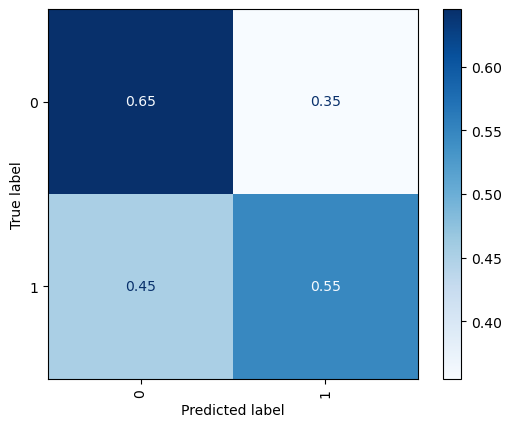

In [35]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(ytest, yhat, labels=grid_search.best_estimator_.classes_,
                                        xticks_rotation="vertical", normalize="true",
                                        cmap=plt.cm.Blues)

# Citing this notebook

If you use this notebook in your work, please cite it as follows:
    
Pekar, V. (2024). Big Data for Decision Making. Lecture examples and exercises. (Version 1.0.0). URL: https://github.com/vpekar/bd4dm